In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [79]:
df = pd.read_excel(r"C:\Users\ASUS\OneDrive\Desktop\ML\Regression - Project\premiums_young.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [80]:
df.shape

(20096, 13)

In [81]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

### Data Cleaning

In [83]:
# Data Inconsistency -> some columns have spaces, others have _

In [84]:
df.columns = df.columns.str.replace(' ', '_').str.lower() #assign it back
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


### Handling NA values

In [86]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [87]:
# in context of size of dataset, not that many

In [88]:
df.dropna(inplace = True)

In [89]:
df.duplicated().sum()
df.drop_duplicates(inplace = True)
df.duplicated().sum()


0

In [90]:
df.describe() #For numeric columns

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [91]:
# age 356 -> error
# number of dependents is a negative value -> error
# income_lakhs 930 lakhs (9.3 Cr) - > skewed distribution

### Univariate Analysis

In [93]:
df[df.number_of_dependants < 0].shape

(22, 13)

In [94]:
# 72 rows with less than 0 dependents

In [95]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-3, -1], dtype=int64)

In [96]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [97]:
# Vizulaizing Outliers

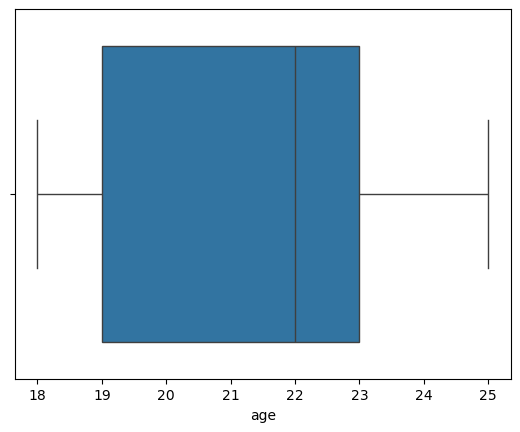

In [98]:
sns.boxplot(x = df['age'])
plt.show()

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20090 entries, 0 to 20095
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    20090 non-null  int64 
 1   gender                 20090 non-null  object
 2   region                 20090 non-null  object
 3   marital_status         20090 non-null  object
 4   number_of_dependants   20090 non-null  int64 
 5   bmi_category           20090 non-null  object
 6   smoking_status         20090 non-null  object
 7   employment_status      20090 non-null  object
 8   income_level           20090 non-null  object
 9   income_lakhs           20090 non-null  int64 
 10  medical_history        20090 non-null  object
 11  insurance_plan         20090 non-null  object
 12  annual_premium_amount  20090 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 2.1+ MB


In [100]:
# All numeric ones are either float64 or int 64

In [101]:
df.select_dtypes(['float64', 'int64'])

,age,number_of_dependants,income_lakhs,annual_premium_amount
0,18,0,99,13365
1,22,0,3,11050
2,21,0,97,11857
3,25,0,15,5684
4,20,2,14,5712
...,...,...,...,...
20091,18,0,91,11603
20092,23,0,57,14498
20093,24,0,35,9111
20094,21,0,32,8564


In [102]:
df_numeric_columns = df.select_dtypes(['float64', 'int64']).columns
df_numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

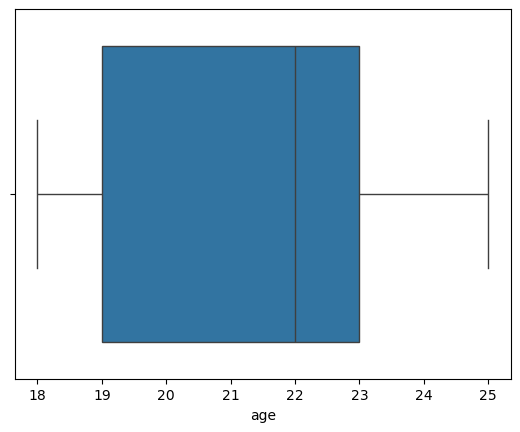

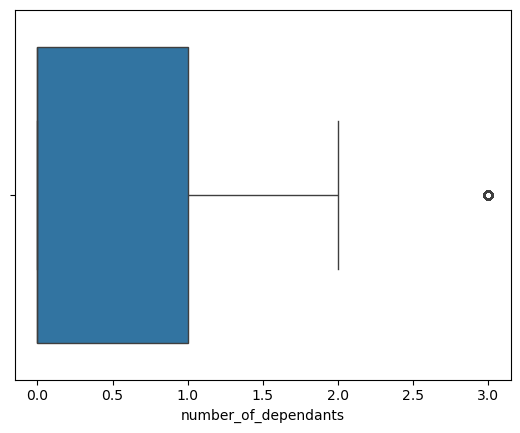

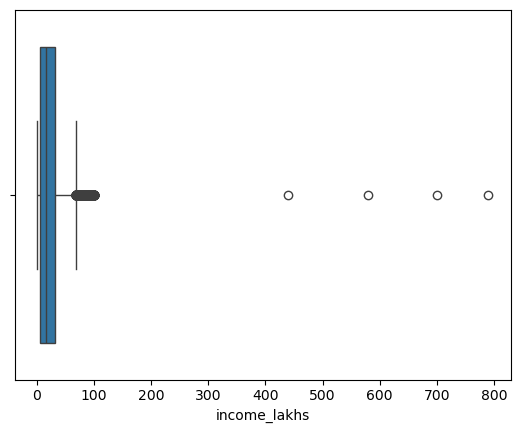

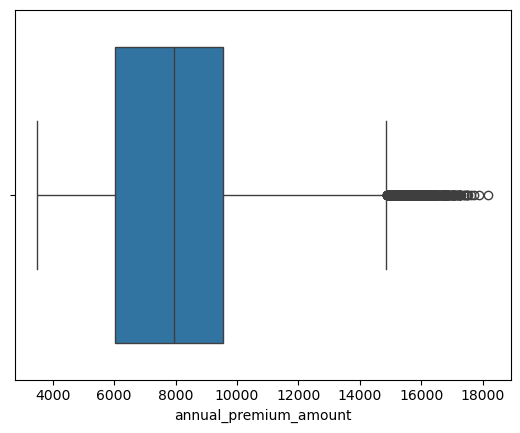

In [103]:
for col in df_numeric_columns:
    sns.boxplot(x = df[col])
    plt.show()
    

In [104]:
df[df.age>100]['age'].value_counts()

Series([], Name: count, dtype: int64)

In [105]:
df[df.age>100]['age'].unique()

array([], dtype=int64)

In [106]:
#we can drop them

In [107]:
df1 = df[df.age <=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

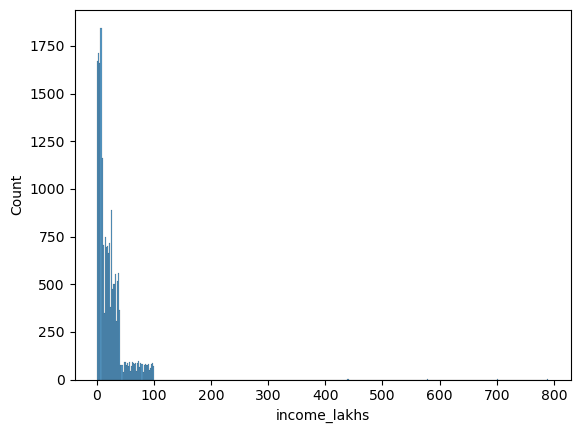

In [108]:
sns.histplot(df1.income_lakhs)

In [109]:
Q1,Q3 = df.income_lakhs.quantile([0.25,0.75])
Q1,Q3

(6.0, 31.0)

In [110]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [111]:
get_iqr_bounds(df1.income_lakhs)

(-31.5, 68.5)

In [112]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [113]:
df1[df1.income_lakhs > quantile_threshold]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
1677,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,440,No Disease,Silver,10636
4311,20,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,580,Thyroid,Silver,12888
4661,21,Female,Southwest,Unmarried,0,Obesity,No Smoking,Freelancer,> 40L,700,No Disease,Bronze,7424
6251,21,Female,Southeast,Unmarried,0,Normal,Occasional,Salaried,> 40L,790,No Disease,Silver,7586


In [114]:
df1[df1.income_lakhs > quantile_threshold].shape

(4, 13)

In [115]:
df2 =df1[ df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


In [116]:
# not many outliers in annual_premium_amount -> let it be as is

In [117]:
# histogram -> right skewed, left skewed, the kind of distribution

<Axes: xlabel='income_lakhs', ylabel='Count'>

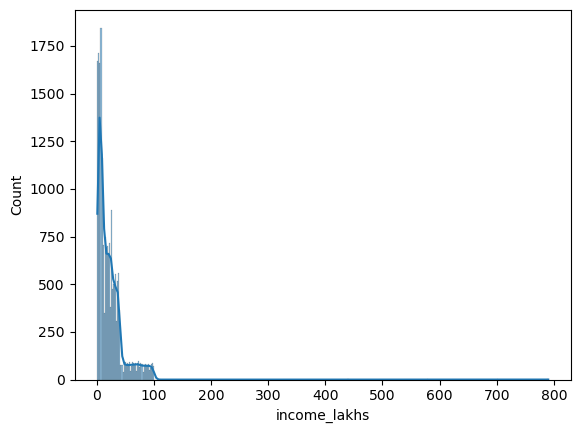

In [118]:
sns.histplot(df1['income_lakhs'],kde = True) # with outliers

<Axes: xlabel='income_lakhs', ylabel='Count'>

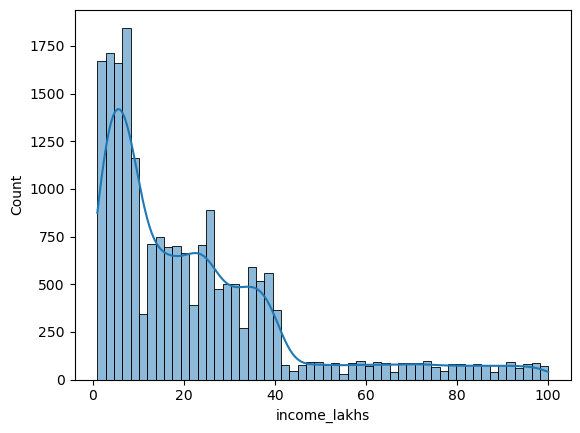

In [119]:
sns.histplot(df2['income_lakhs'],kde = True) # without outliers

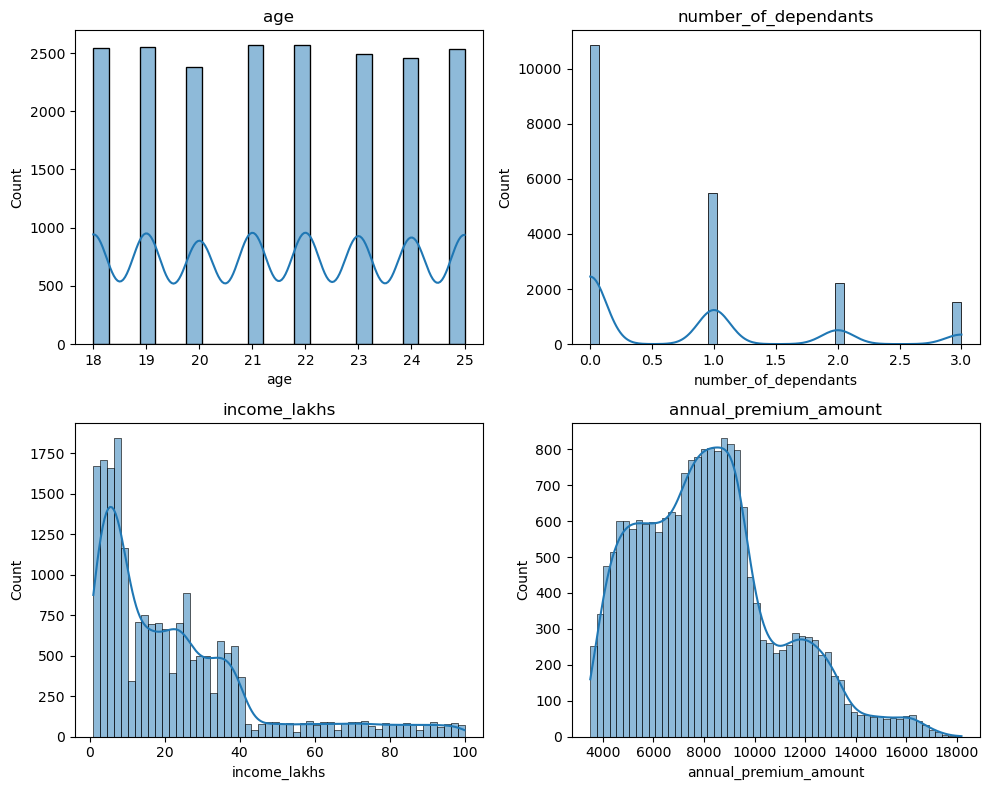

In [120]:
fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

for i,col in enumerate(df_numeric_columns):
    ax = axs[i//2 , i%2] #Determines the position of the subplot in the grid
    sns.histplot(df2[col],kde = True,ax = ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

### Bivariate Analysis

<Axes: xlabel='age', ylabel='annual_premium_amount'>

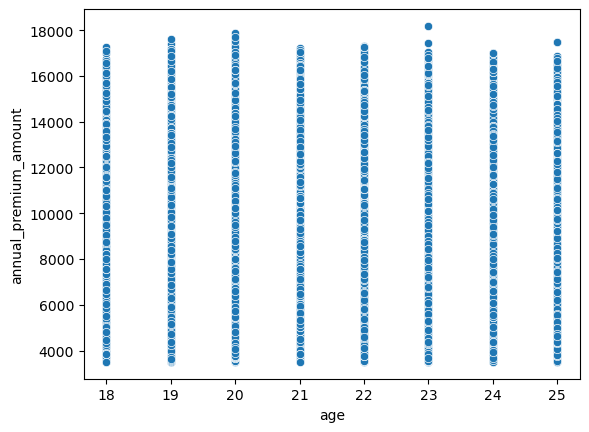

In [122]:
sns.scatterplot(df2, x = 'age', y ='annual_premium_amount')

In [123]:
#age increases, annual premium amount increases -> positive correlation/

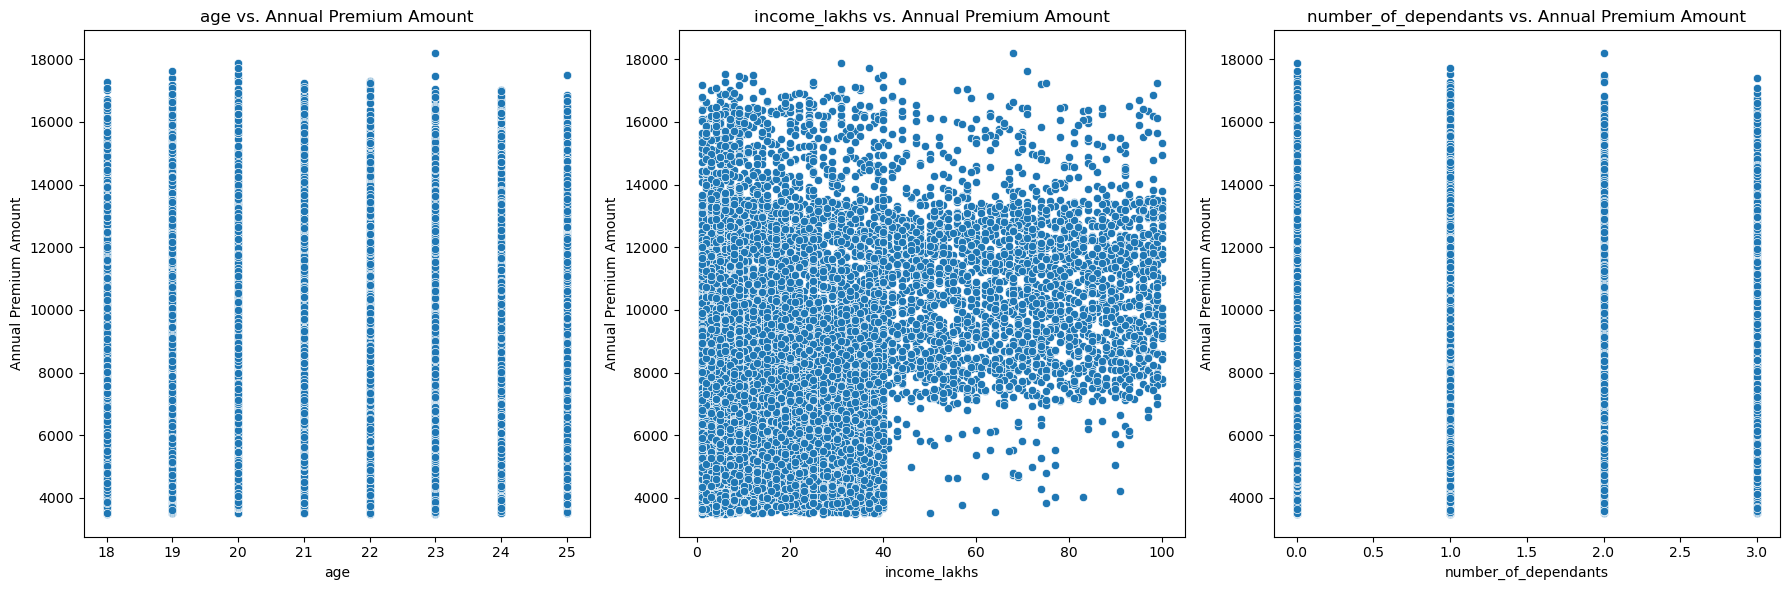

In [124]:
numeric_features = ['age' , 'income_lakhs', 'number_of_dependants']

fig,axes = plt.subplots(1, len(numeric_features), figsize = (18,6)) 

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x = df2[column], y =df2['annual_premium_amount'],ax = ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show()

In [125]:
# no clear correlation between income_lakhs and number_of_dependants

In [126]:
categorical_df = df.select_dtypes('object')
categorical_df

,gender,region,marital_status,bmi_category,smoking_status,employment_status,income_level,medical_history,insurance_plan
0,Male,Northeast,Unmarried,Overweight,Regular,Self-Employed,> 40L,High blood pressure,Silver
1,Female,Northwest,Unmarried,Underweight,No Smoking,Freelancer,<10L,No Disease,Silver
2,Female,Southeast,Unmarried,Normal,Regular,Salaried,> 40L,No Disease,Silver
3,Male,Southeast,Unmarried,Normal,No Smoking,Freelancer,10L - 25L,No Disease,Bronze
4,Male,Southeast,Unmarried,Overweight,No Smoking,Freelancer,10L - 25L,No Disease,Bronze
...,...,...,...,...,...,...,...,...,...
20091,Female,Southeast,Unmarried,Underweight,No Smoking,Freelancer,> 40L,No Disease,Gold
20092,Female,Northwest,Unmarried,Obesity,Occasional,Freelancer,> 40L,Diabetes,Gold
20093,Female,Northwest,Unmarried,Underweight,No Smoking,Self-Employed,25L - 40L,No Disease,Bronze
20094,Male,Northwest,Unmarried,Normal,Regular,Freelancer,25L - 40L,No Disease,Bronze


In [127]:
categorical_cols = df.select_dtypes('object').columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [128]:
for col in categorical_cols:
    print(col, ":" , df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [129]:
# presence of non uniform values in smoking_status columns

In [130]:
df2['smoking_status'].replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
} , inplace = True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2328\3676593068.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


In [131]:
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [132]:
df2.gender.value_counts()

gender
Male      11055
Female     9031
Name: count, dtype: int64

In [133]:
pct_count = df2.gender.value_counts(normalize = True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

In [134]:
pct_count.index

Index(['Male', 'Female'], dtype='object', name='gender')

In [135]:
pct_count.values

array([0.55038335, 0.44961665])

<Axes: xlabel='gender'>

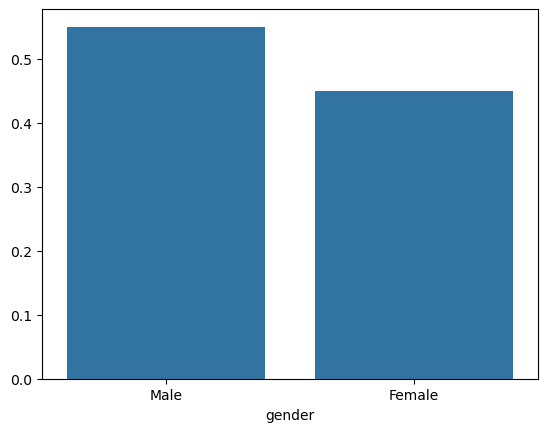

In [136]:
sns.barplot(x = pct_count.index, y = pct_count.values)

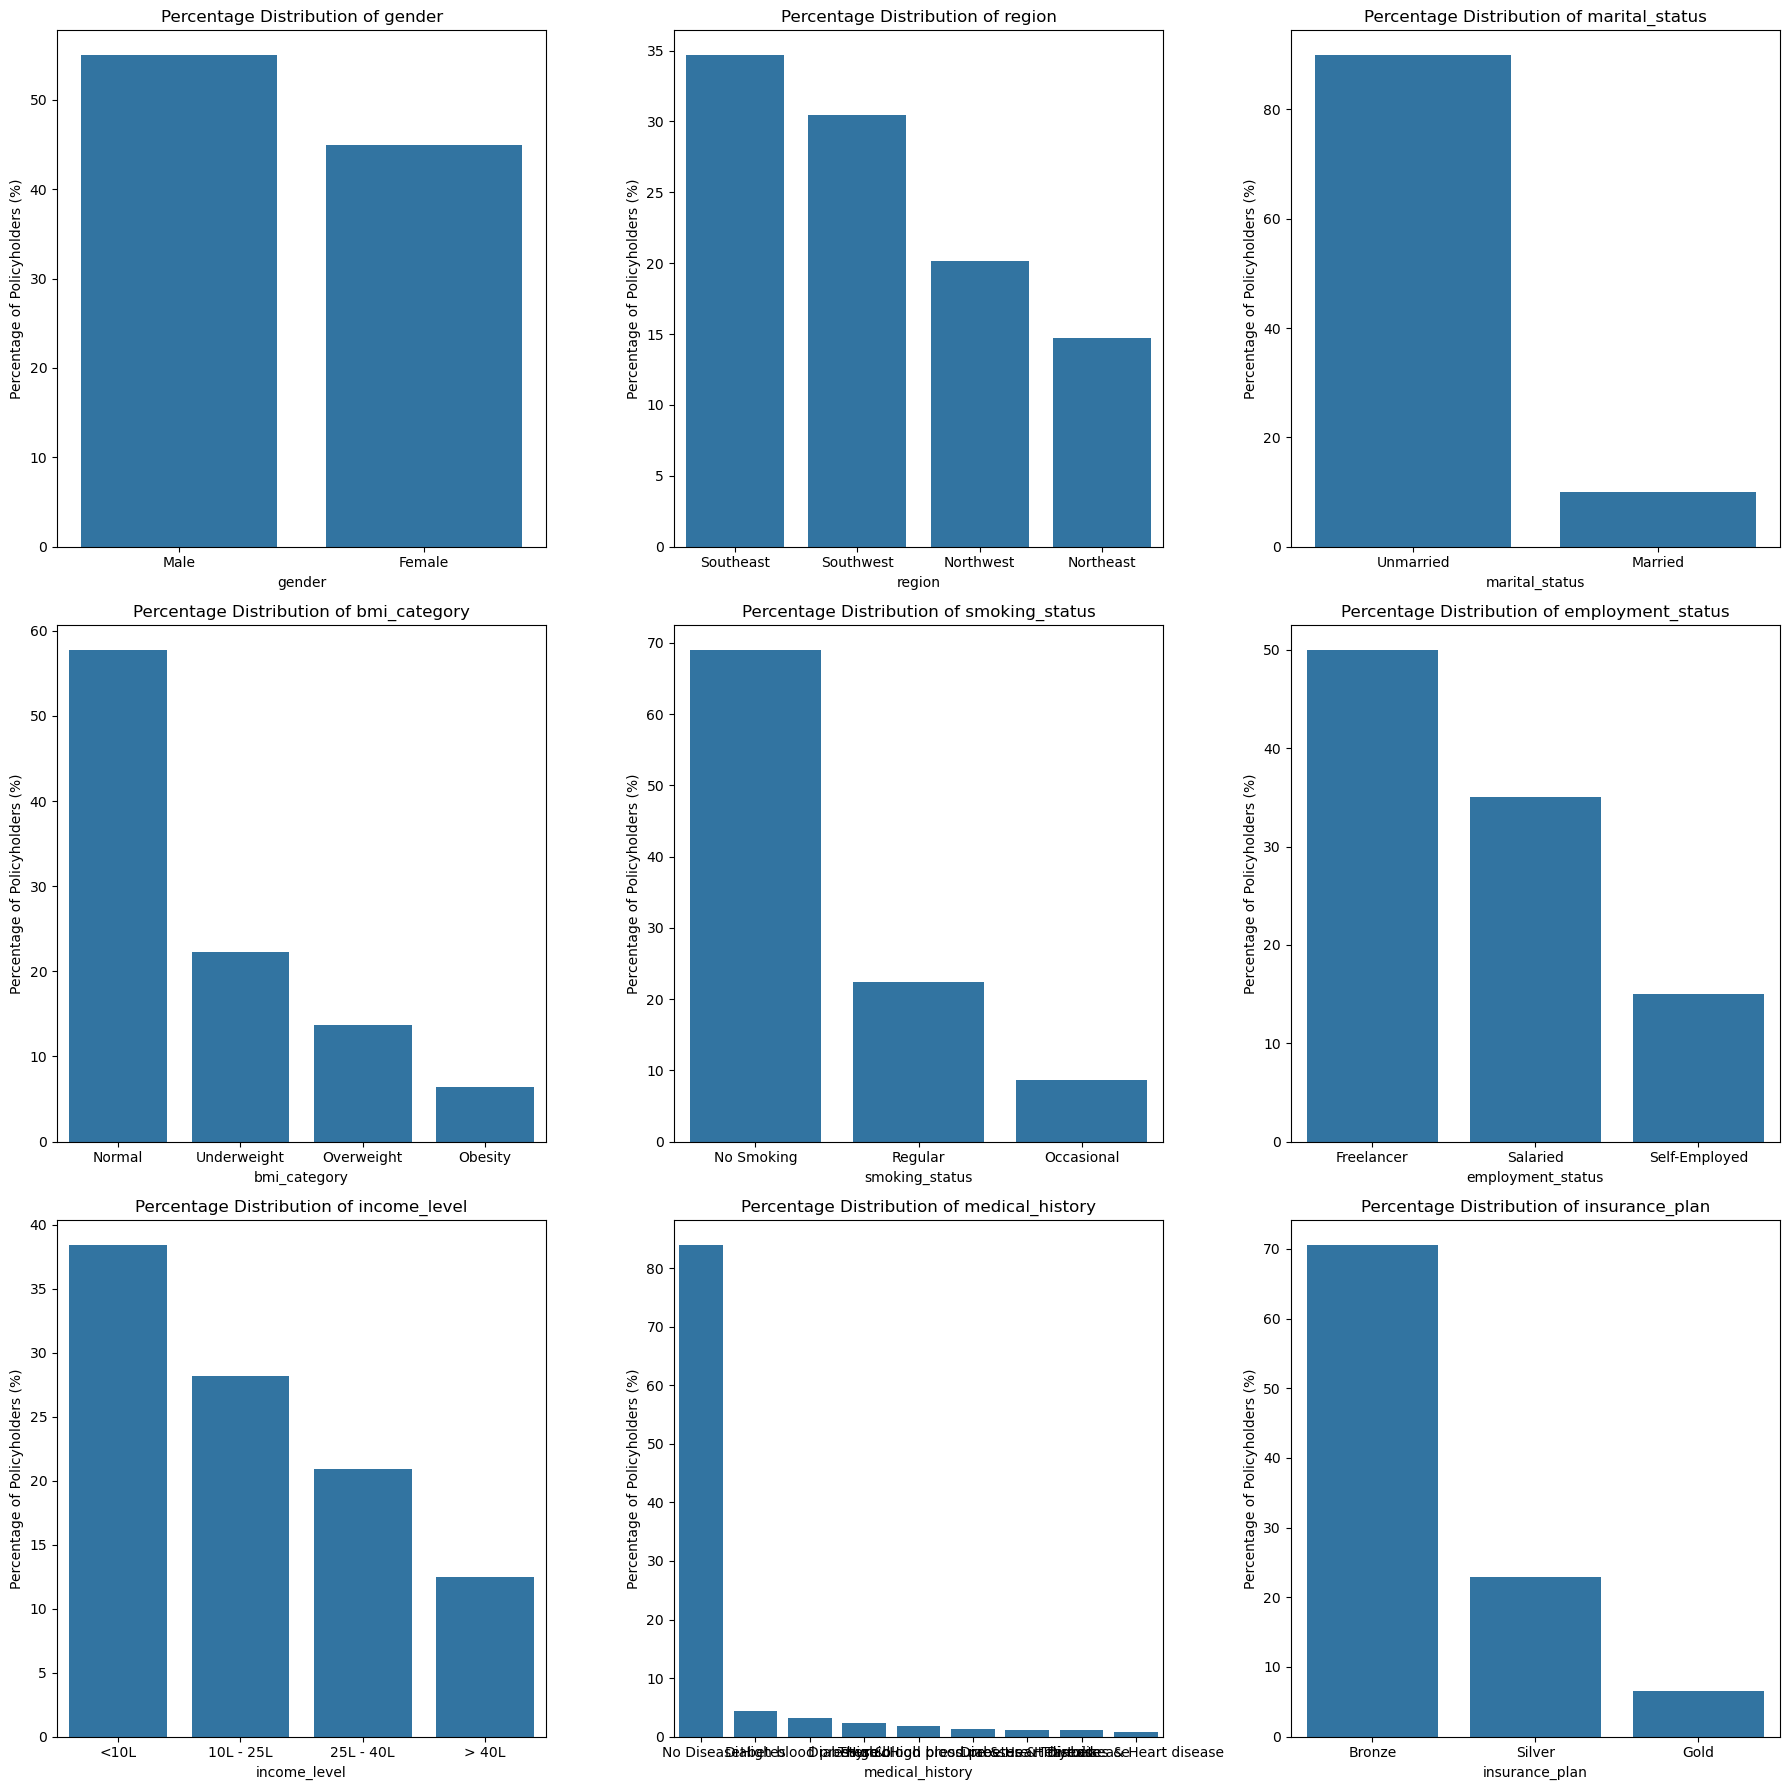

In [137]:
fig,axes = plt.subplots(3,3,figsize = (18,18))
axes = axes.flatten() # flatten the 2D array of axes into 1D for easier iteration

for ax,column in zip (axes, categorical_cols):
    #calc the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize = True) * 100

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index , y = category_counts.values, ax = ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel(f'Percentage of Policyholders (%)')
    ax.set_xlabel(column) 

plt.tight_layout()
plt.show()

In [138]:
crosstab = pd.crosstab(df2['income_level'] , df2['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,366,2023


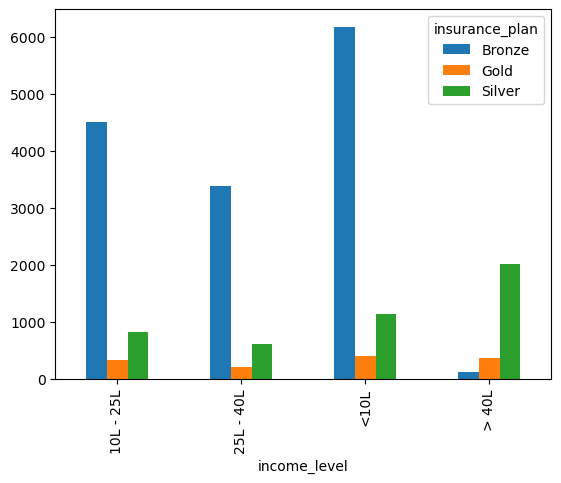

In [139]:
crosstab.plot(kind = "bar")
plt.show()

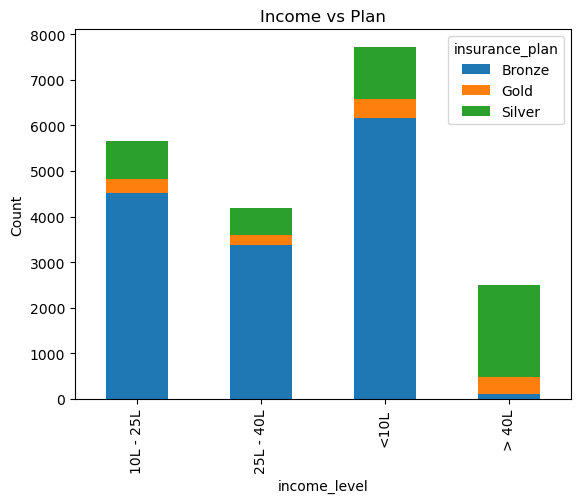

In [140]:
crosstab.plot(kind = "bar",stacked = True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

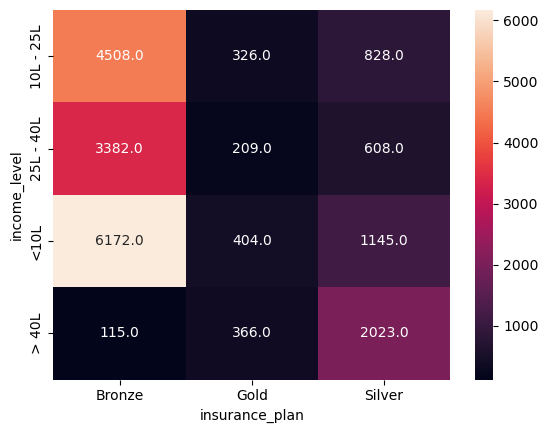

In [141]:
sns.heatmap(crosstab, annot = True, fmt = '.1f')

In [142]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


In [143]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [144]:
# higher number of pre-existing diseases -> higher premium

In [145]:
risk_score = {
    "diabetes" : 6,
    "heart disease": 8,
    "high blood pressure" : 6,
    "thyroid" : 5,
    "no disease" : 0,
    "none" : 0
}

df2['medical_history'].str.split(" & ")

0        [High blood pressure]
1                 [No Disease]
2                 [No Disease]
3                 [No Disease]
4                 [No Disease]
                 ...          
20091             [No Disease]
20092               [Diabetes]
20093             [No Disease]
20094             [No Disease]
20095             [No Disease]
Name: medical_history, Length: 20086, dtype: object

In [146]:
df2['medical_history'].str.split(" & ", expand = True)

,0,1
0,High blood pressure,None
1,No Disease,None
2,No Disease,None
3,No Disease,None
4,No Disease,None
...,...,...
20091,No Disease,None
20092,Diabetes,None
20093,No Disease,None
20094,No Disease,None


In [147]:
df2['medical_history'].str.split(" & ", expand = True).apply(lambda x: x.str.lower()).sample(10)

,0,1
16806,thyroid,None
16052,no disease,None
7452,no disease,None
12167,no disease,None
10883,no disease,None
8106,no disease,None
9292,no disease,None
10261,no disease,None
15778,no disease,None
11308,no disease,None


In [148]:
df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ",expand = True).apply(lambda x : x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None


In [149]:
df2['disease1'].fillna('none',inplace = True)
df2['disease2'].fillna('none',inplace = True)
df2['total_risk_score'] = 0 

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_score)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2328\914496287.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none',inplace = True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2328\914496287.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,none,0,0.000000


In [150]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [151]:
# ordinal (order) category -> label encoding

In [152]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze' : 1, 'Silver' : 2, 'Gold' : 3})
df2.insurance_plan.unique()

array([2, 1, 3], dtype=int64)

In [153]:
df2['income_level'].unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [154]:
df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L' : 3, '> 40L' : 4})
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,no disease,none,0,0.000000


In [155]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns = nominal_cols, drop_first = True, dtype = int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,no disease,none,0,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,no disease,none,0,...,1,0,1,0,1,0,0,0,0,0


In [156]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis = 1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


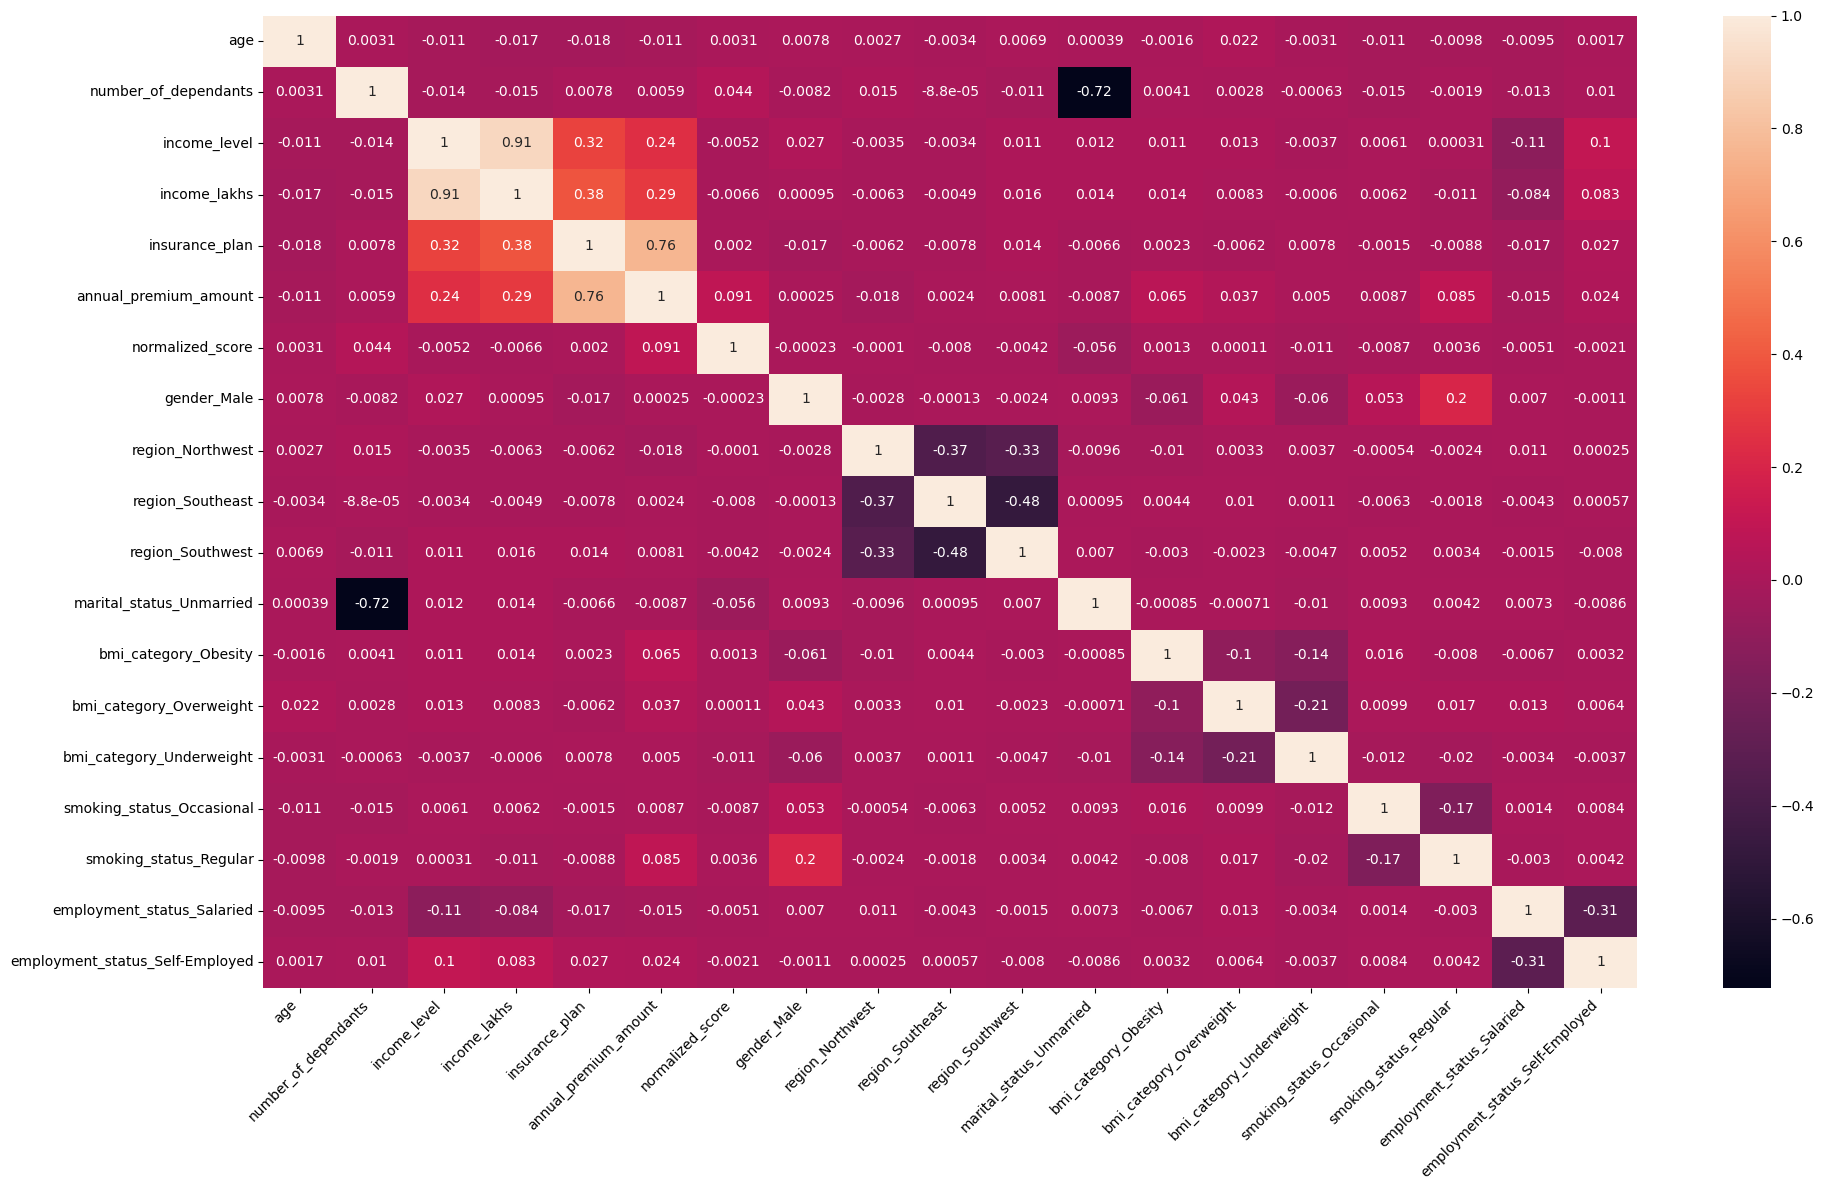

In [157]:
cm = df4.corr()

plt.figure(figsize = (20,12))
sns.heatmap(cm, annot = True)
plt.xticks(rotation = 45, ha ='right')
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

In [158]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


In [159]:
X = df4.drop('annual_premium_amount', axis = 'columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan',]

scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,1.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.333333,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.333333,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


In [160]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Variable'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [161]:
calculate_vif(X)

,Variable,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


In [162]:
#income level and income lakhs vif higher than 10 - they are extremely correlated.

In [163]:
calculate_vif(X.drop('income_level', axis = 'columns'))

,Variable,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [164]:
X_reduced = X.drop('income_level', axis = 'columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Model Training

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size = 0.3, random_state = 10)

In [167]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

train_score = model_lr.score(X_train,y_train)
test_score = model_lr.score(X_test,y_test)

train_score,test_score

(0.6020471274164894, 0.6047589163893645)

In [168]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  3005669.8791236714 RMSE:  1733.6867880686152


In [169]:
# both same, sometimes if train score is greater than test score than it is overfitting

In [170]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12774,1.0,0.666667,0.040404,0.0,0.0,1,0,0,1,1,0,0,1,0,0,0,0


In [171]:
model_lr.coef_

array([ 5.51905147e+01, -1.45039643e+02, -3.60667677e+01,  7.00007042e+03,
        1.11127879e+03,  9.82564766e+00, -1.14273450e+02, -3.64663714e+01,
       -6.72232248e+01, -5.85343424e+01,  7.92952660e+02,  4.35760406e+02,
        1.69728916e+02,  2.44813937e+02,  6.19082947e+02, -1.30535485e+01,
       -4.34272200e+00])

In [172]:
model_lr.intercept_

6614.58339123075

In [173]:
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [174]:
feature_importances = model_lr.coef_ #other models have a feature importance function. LR -> coefficients

coef_df = pd.DataFrame(feature_importances,index = X_test.columns, columns = ['Coefficients'])
coef_df = coef_df.sort_values(by = 'Coefficients' , ascending = True)
coef_df

,Coefficients
number_of_dependants,-145.039643
region_Northwest,-114.273450
region_Southwest,-67.223225
marital_status_Unmarried,-58.534342
region_Southeast,-36.466371
income_lakhs,-36.066768
employment_status_Salaried,-13.053549
employment_status_Self-Employed,-4.342722
gender_Male,9.825648
age,55.190515


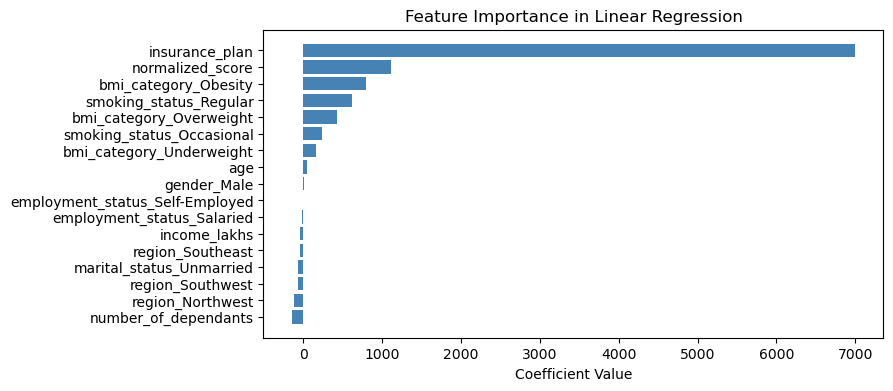

In [175]:
plt.figure(figsize = (8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color = 'steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [176]:
model_rg = Ridge()
model_rg.fit(X_train,y_train)
train_score = model_rg.score(X_train,y_train)
test_Score = model_rg.score(X_test,y_test)
train_score,test_score

(0.6020466631305188, 0.6047589163893645)

In [177]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train,y_train)
train_score = model_xgb.score(X_train,y_train)
test_Score = model_xgb.score(X_test,y_test)
train_score,test_score

(0.7251047267247346, 0.6047589163893645)

In [178]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  3316548.97851731 RMSE:  1821.1394725603282


In [179]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators' : [20,40,50],
    'learning_rate' : [0.01,0.1,0.2],
    'max_depth' : [3,4,5]
}

random_search = RandomizedSearchCV(model_xgb,param_grid, n_iter = 10, cv = 3, scoring = 'r2', random_state = 42)
random_search.fit(X_train, y_train)
random_search.best_score_

0.5997089124277125

In [180]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [181]:
best_model = random_search.best_estimator_

In [336]:
best_model = model_lr

In [183]:
# AS XGBoost is tree-based, interpretation of feature importance is not as straightforward as Linear Regression

### Error Analysis

In [185]:
# Can't rely only on R2 score to deploy the model. Need to find the margin of error in each of the sample

In [338]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals*100)/y_test

results_df = pd.DataFrame ({
    'actual' : y_test,
    'predicted' : y_pred,
    'Delta' : residuals,
    'Delta_pct' : residuals_pct
})
results_df.head()

,actual,predicted,Delta,Delta_pct
12774,6238,6625.420564,387.420564,6.210653
14758,9462,7117.148903,-2344.851097,-24.781770
13205,5152,7052.316369,1900.316369,36.885023
14278,6988,7924.504344,936.504344,13.401608
19351,4917,6696.274716,1779.274716,36.186185


<Axes: xlabel='Delta_pct', ylabel='Count'>

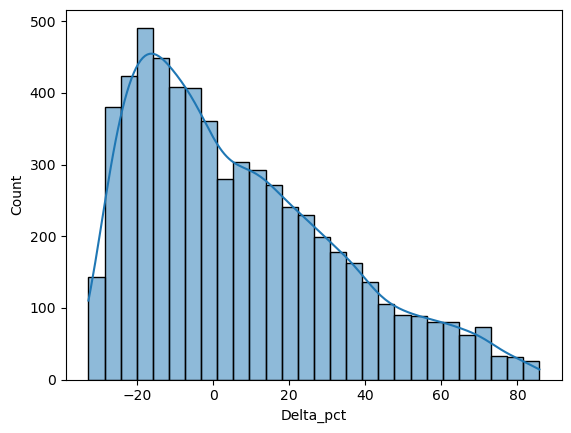

In [340]:
sns.histplot(results_df['Delta_pct'], kde = True)

In [188]:
# how many records with more than 10% error

In [342]:
extreme_threshold = 10

extreme_results_df = results_df[np.abs(results_df.Delta_pct) > extreme_threshold]
extreme_results_df.shape

(4404, 4)

In [190]:
results_df.shape

(6026, 4)

In [344]:
extreme_error_pct = extreme_results_df.shape[0] * 100 / results_df.shape[0]
extreme_error_pct

73.08330567540658

In [346]:
results_df[np.abs(results_df.Delta_pct) > 50].sort_values('Delta_pct',ascending = False)

,actual,predicted,Delta,Delta_pct
10288,3623,6730.355627,3107.355627,85.767475
16580,3538,6566.644257,3028.644257,85.603286
3652,3536,6560.929382,3024.929382,85.546645
17084,3562,6608.314334,3046.314334,85.522581
18629,3616,6684.432249,3068.432249,84.857087
...,...,...,...,...
1597,4653,6988.954171,2335.954171,50.203184
12185,4440,6666.968404,2226.968404,50.156946
15966,4709,7070.742860,2361.742860,50.153809
4086,4592,6890.471576,2298.471576,50.053824


In [193]:
extreme_results_df.index

Index([14758, 13205, 14278, 19351, 10622, 14799, 16348,  5573,  5634, 14882,
       ...
        5484,  8988,  8695,  9658,  1365,   399, 17652,  5807, 10298, 13316],
      dtype='int64', length=4407)

In [194]:
#high margin errors in X_test

In [348]:
extreme_error_df = X_test.loc[extreme_results_df.index]
extreme_error_df

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
10622,0.428571,0.333333,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.142857,0.666667,0.111111,0.0,0.785714,0,0,0,1,1,0,0,1,0,0,1,0
17652,0.571429,0.000000,0.343434,0.0,0.000000,1,0,0,0,1,0,0,0,0,0,1,0
5807,0.857143,0.333333,0.040404,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,0
10298,0.000000,0.000000,0.111111,0.5,0.000000,1,0,1,0,1,0,1,0,0,1,1,0


In [196]:
# is error rate highre in specific income group

<Axes: xlabel='income_lakhs', ylabel='Count'>

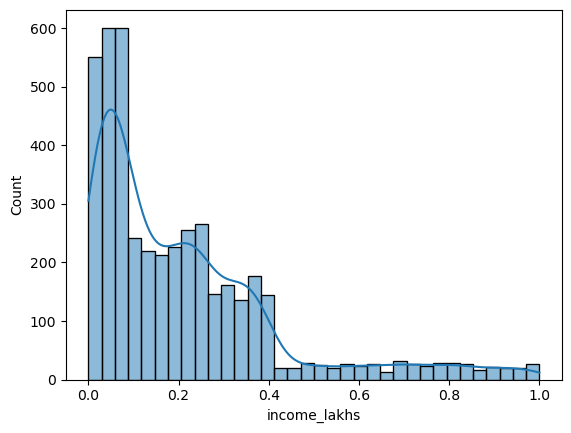

In [350]:
sns.histplot(extreme_error_df.income_lakhs, kde = True)

In [198]:
# No insight need some base case to compare it against

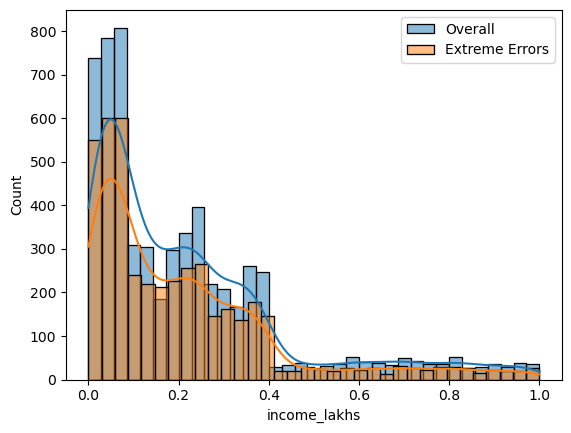

In [352]:
sns.histplot(X_test.income_lakhs, label = "Overall" , kde = True)
sns.histplot(extreme_error_df.income_lakhs,label = "Extreme Errors", kde = True)
plt.legend()
plt.show()

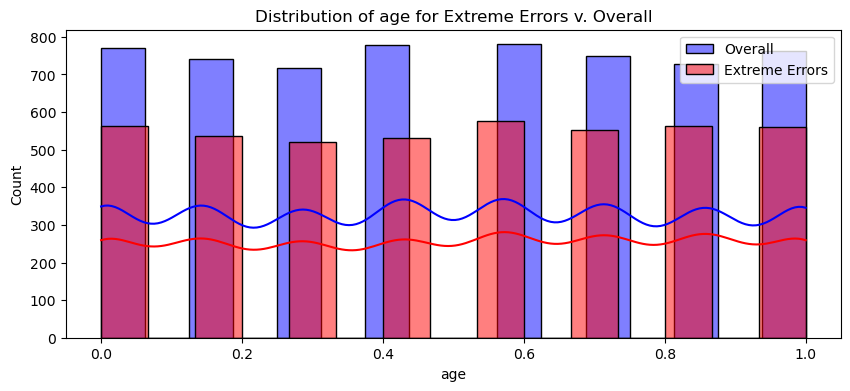

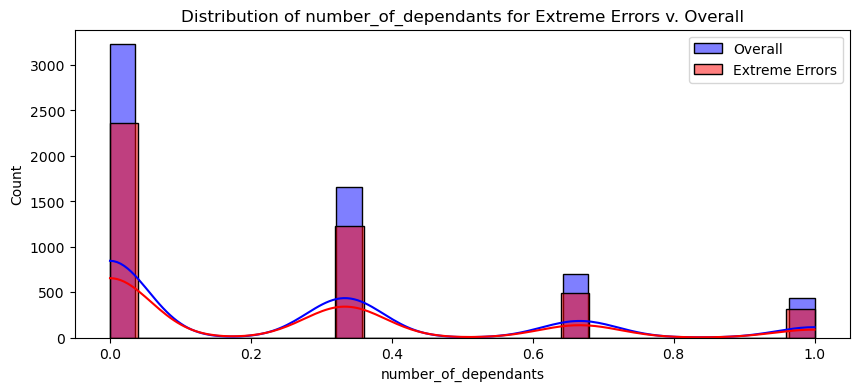

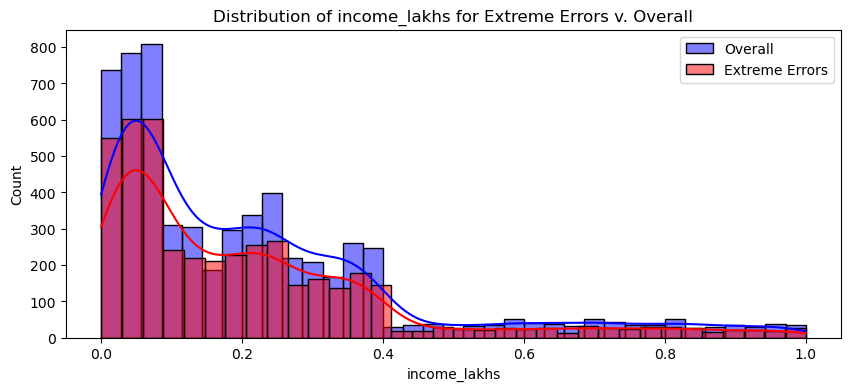

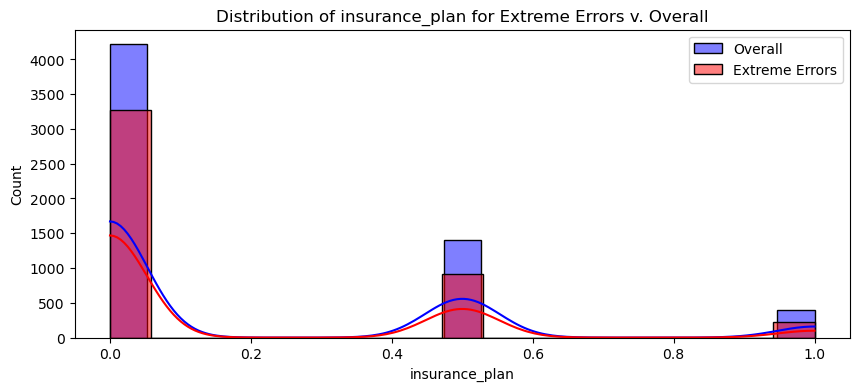

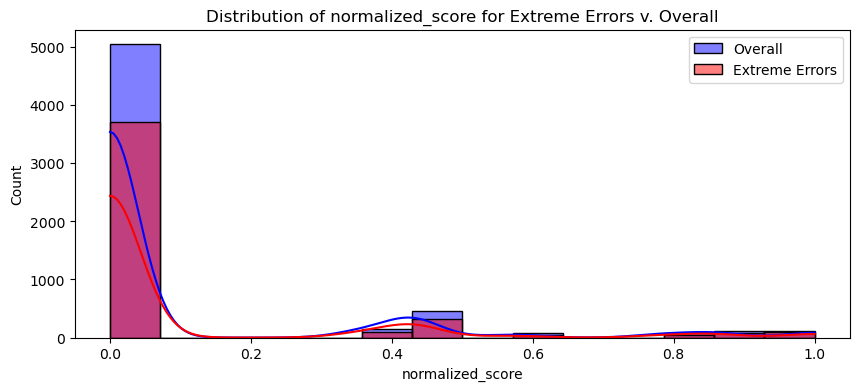

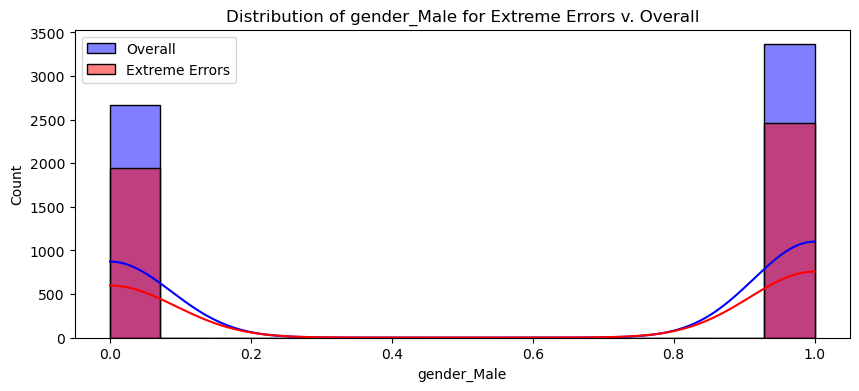

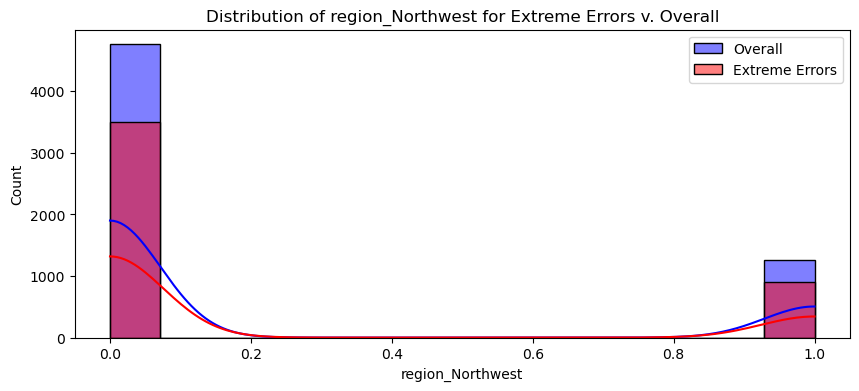

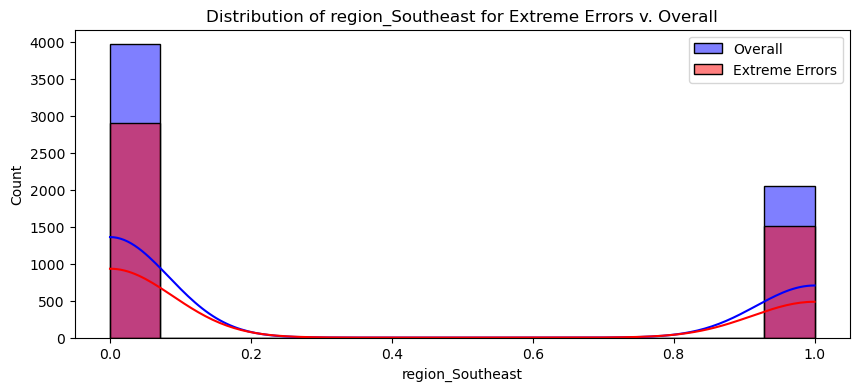

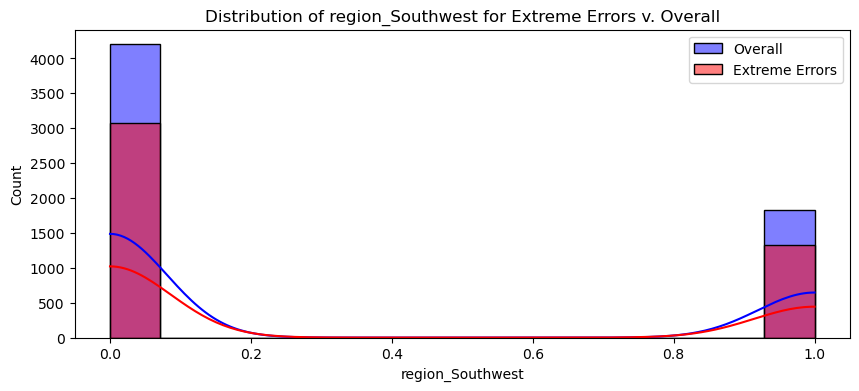

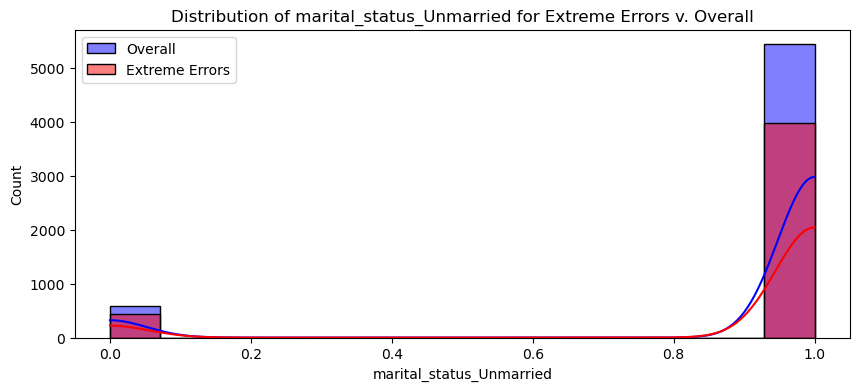

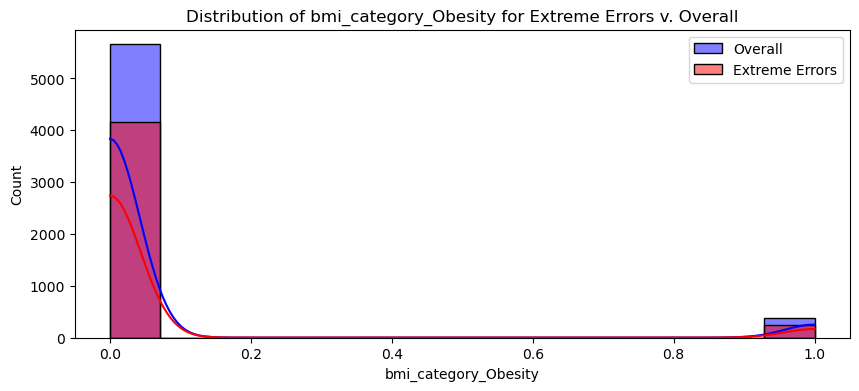

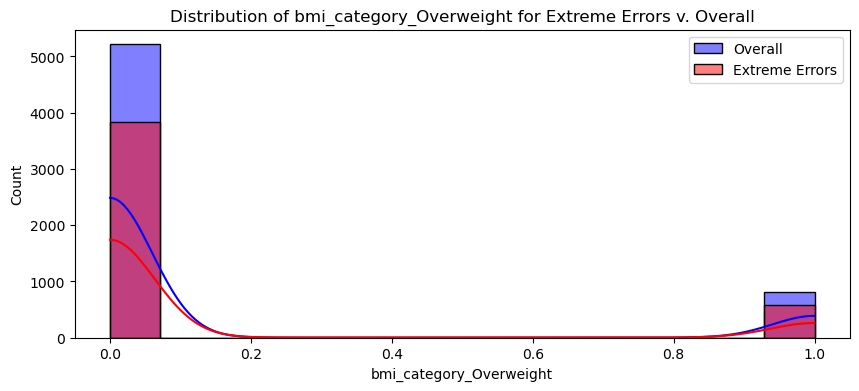

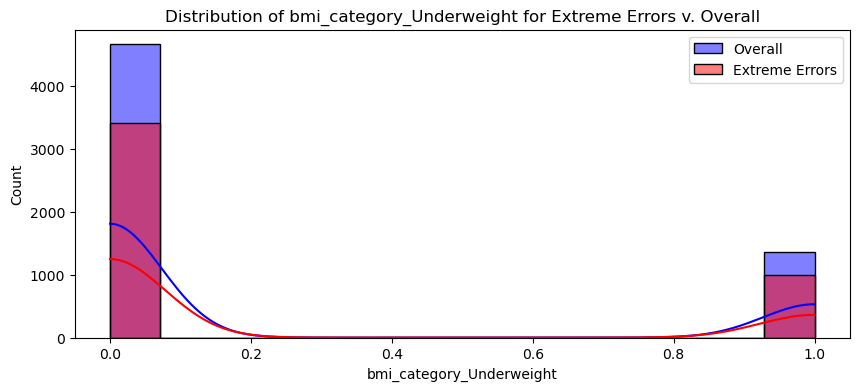

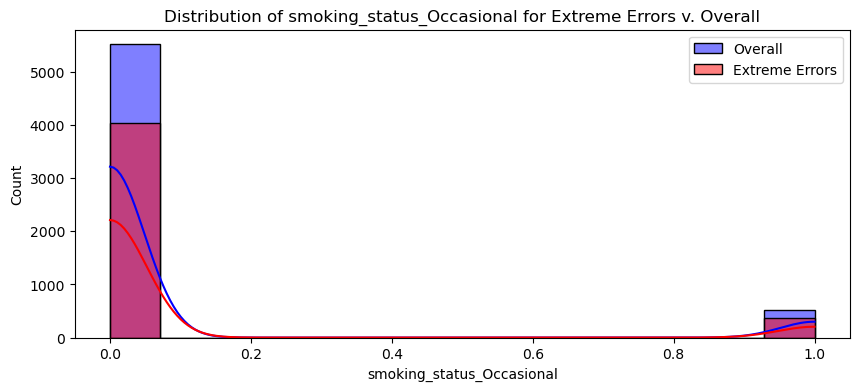

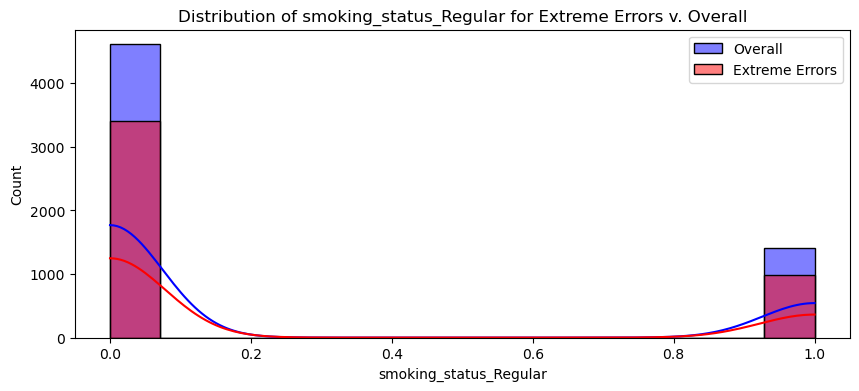

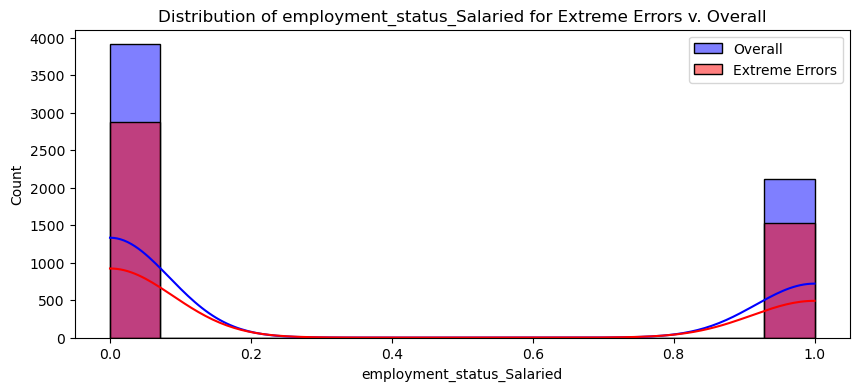

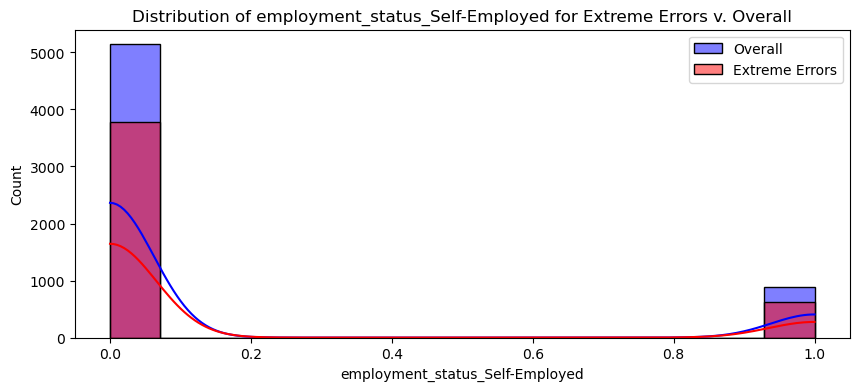

In [354]:
for feature in X_test.columns:
    plt.figure(figsize = (10,4))
    sns.histplot(X_test[feature],color = 'blue', label = "Overall" , alpha = 0.5,kde = True)
    sns.histplot(extreme_error_df[feature], color = 'red', label = "Extreme Errors", kde = True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors v. Overall')
    plt.show()

frequencies in X test are similar to frequencies of Extreme Erros

<Axes: xlabel='age', ylabel='Count'>

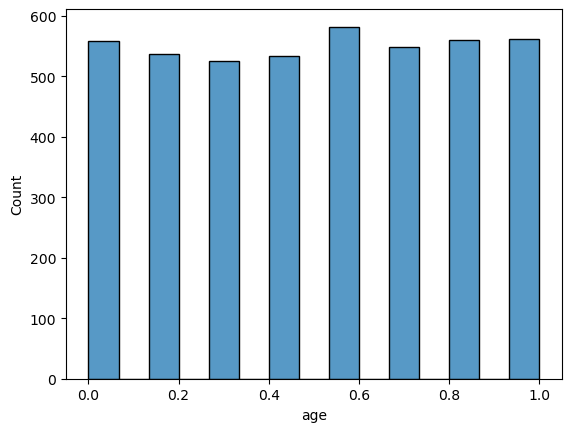

In [203]:
sns.histplot(extreme_error_df.age)

In [356]:
# Features not able to explain variance in our target variable, need more data/features
# or trying different feature engineering techniques

In [204]:
extreme_error_df.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [205]:
extreme_error_df['income_level'] = -1 #don't necessarily need the column but need for the object to work

In [206]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_error_df[cols_to_scale])
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,20.0,0.0,-2.0,7.0,1.0
1,23.0,1.0,-2.0,15.0,1.0
2,23.0,1.0,-2.0,23.0,1.0
3,22.0,0.0,-2.0,11.0,1.0
4,21.0,1.0,-2.0,6.0,1.0
...,...,...,...,...,...
4402,19.0,2.0,-2.0,12.0,1.0
4403,22.0,0.0,-2.0,35.0,1.0
4404,24.0,1.0,-2.0,5.0,1.0
4405,18.0,0.0,-2.0,12.0,2.0


<Axes: xlabel='age', ylabel='Count'>

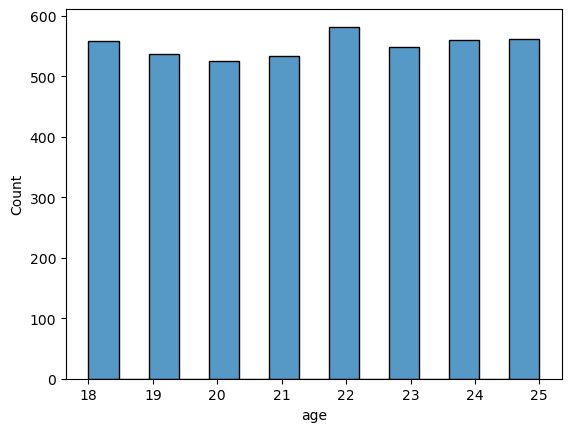

In [207]:
sns.histplot(df_reversed['age'])

In [208]:
cdf_reversed['age'].describe()

count    4407.000000
mean       21.529158
std         2.298631
min        18.000000
25%        20.000000
50%        22.000000
75%        24.000000
max        25.000000
Name: age, dtype: float64